# Introduction

This notebook will be used to complete the kaggle competition `Spaceship-Titanic`

## Imports


In [2]:

# Operating system
import os
import time
from joblib import dump, load

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

# Models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna

# Metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# Misc
import names


/home/mattgpaul/Documents/Python Projects/Spaceship-Titanic/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.getcwd()

'/home/mattgpaul/Documents/Python Projects/Spaceship-Titanic'

## Import Train/Test Data

In [4]:
train = pd.read_csv(os.getcwd() + '/data/train.csv')
test = pd.read_csv(os.getcwd() + '/data/test.csv')

In [5]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## Data Exploration

In [8]:
def MissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    md = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    md = md[md['Percent'] > 0]
    
    return md

In [9]:
missing_train = MissingData(train)
missing_train

,Total,Percent
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


In [10]:
missing_test = MissingData(test)
missing_test

,Total,Percent
FoodCourt,106,2.478373
Spa,101,2.361468
Cabin,100,2.338087
ShoppingMall,98,2.291326
Name,94,2.197802
CryoSleep,93,2.174421
VIP,93,2.174421
Destination,92,2.151040
Age,91,2.127660
HomePlanet,87,2.034136


In [11]:
def UniqueCategorical(df):
    cats = df[df.dtypes[df.dtypes == 'object'].index]
    cat_stats = cats.describe()
    pct_unique = (cat_stats.loc['unique']/cat_stats.loc['count'])*100
    
    return pct_unique

In [12]:
train_unique_cats = UniqueCategorical(train)
train_unique_cats

PassengerId        100.0
HomePlanet      0.035327
CryoSleep       0.023596
Cabin          77.230987
Destination     0.035249
VIP             0.023557
Name           99.764512
dtype: object

In [13]:
test_unique_cats = UniqueCategorical(test)
test_unique_cats

PassengerId        100.0
HomePlanet      0.071599
CryoSleep       0.047801
Cabin          78.166148
Destination     0.071685
VIP             0.047801
Name           99.832656
dtype: object

# Data Cleaning

So it looks like I have both empty values and some very large outliers.

## Null Values

Not very large percentage of missing values, about `2.5%` for both the training and the test set. Therefore, it is safe to say we dont need to drop any features from the dataset. However, we do need to fill these values. In light of the fact that we have some pretty hefty outliers, it makes sense to use the median rather than the mean to fill the values. However, we may come back and change this if our cleaning of outliers causes us to revert back to using a mean, assuming it makes more sense.

## Outliers

Based on our `std` and `max` values from our describe method for the train and test set, we have someone who is spending quite a lot on amenities. A good approach here is to perhaps identify how many data points are outside a high quantile for the data (say `90%`?). If there are relatively low number of data points in that area that represent the outliers we are seeing, and especially if they all belong to the same person/people, it may be worth simply assigning a more appropriate value to the data, rather than just dropping it. Who knows, this will likely take some trial and error.

In [14]:
numbers = [col for col in train.columns if train[col].dtype in ['int64','float64']]
numbers_no_age = [col for col in numbers if col != 'Age']
categories = [col for col in train.columns if train[col].dtype == 'object' and col != 'Transported']

We know there are null values in the `Age` feature, based on what we saw earlier. But are there any that equal 0?

In [15]:
train[train['Age'] <= 0.0]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True
61,0067_01,Earth,True,G/10/S,PSO J318.5-22,0.0,False,0.0,0.0,0.0,0.0,0.0,Ninaha Leeves,True
86,0092_02,Earth,True,G/9/P,TRAPPIST-1e,0.0,False,0.0,0.0,NaN,0.0,0.0,Stald Hewson,True
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz,True
157,0179_02,Earth,False,G/26/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Raque Webstephrey,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,9074_01,Earth,True,G/1460/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,NaN,0.0,0.0,Adamie Trerady,True
8584,9163_01,Earth,True,G/1477/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Idace Edwartizman,True
8650,9227_04,Earth,True,G/1498/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Robyny Hinglendez,True
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Walls Paie,True


Yep, about 1% of them are near 0. Does that mean they are infants? or the data simply is not available? My guess is that because there are NaNs in the Age group, that the values we see here are equivalent of infants. Therefore, we will only fill NaN values for the Age group

In [16]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)
MissingData(train)

,Total,Percent
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


An assumption we will make here is regarding missing data for spending and cryosleep. If we assume that someone is in cryosleep, then they probably did not spend any money. The reverse is also true, where if there is a missing value in cryo sleep, and spending is 0, then that person was likely True for cryosleep. Lets fix that first.

In [17]:
train_awake = train[
    ((train['CryoSleep'].isnull()) | (train['CryoSleep'] == False)) & 
    ((train[numbers_no_age].isnull().any(axis=1)) | ((train[numbers_no_age] > 0.0).any(axis=1)))
    ].index

test_awake = test[
    ((test['CryoSleep'].isnull()) | (test['CryoSleep'] == False)) & 
    ((test[numbers_no_age].isnull().any(axis=1)) | ((test[numbers_no_age] > 0.0).any(axis=1)))
    ].index


In [18]:
train.loc[train_awake, 'CryoSleep'] = False
train.loc[train_awake, numbers_no_age] = train.loc[train_awake, numbers_no_age].fillna(0.0)

test.loc[test_awake, 'CryoSleep'] = False
test.loc[test_awake, numbers_no_age] = test.loc[test_awake, numbers_no_age].fillna(0.0)

train.loc[train_awake]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,9275_03,Europa,False,A/97/P,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,Atlasym Conable,True
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [19]:
train_asleep = train[
    ((train['CryoSleep'].isnull()) | (train['CryoSleep'] == True)) & 
    ((train[numbers_no_age].isnull().any(axis=1)) | ((train[numbers_no_age] <= 0.0).any(axis=1)))
    ].index

test_asleep = test[
    ((test['CryoSleep'].isnull()) | (test['CryoSleep'] == True)) & 
    ((test[numbers_no_age].isnull().any(axis=1)) | ((test[numbers_no_age] <= 0.0).any(axis=1)))
    ].index


In [20]:
train.loc[train_asleep, 'CryoSleep'] = True
train.loc[train_asleep, numbers_no_age] = train.loc[train_asleep, numbers_no_age].fillna(0.0)

test.loc[test_asleep, 'CryoSleep'] = True
test.loc[test_asleep, numbers_no_age] = test.loc[test_asleep, numbers_no_age].fillna(0.0)

train.loc[train_asleep]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Candra Jacostaffey,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Altardr Flatic,True
18,0016_01,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Almary Brantuarez,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,9267_02,Europa,True,E/607/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,Sabi Opshaft,True
8680,9268_01,Earth,True,G/1505/P,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Agnesa Baldson,True
8681,9270_01,Earth,True,G/1497/S,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,Lan Mckinsond,True
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True


In [21]:
MissingData(train)

,Total,Percent
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
Destination,182,2.093639


Create a synthetic feature of the sum of all spending done by a passenger

In [22]:
train['TotalExpenses'] = train[numbers_no_age].sum(axis=1)
test['TotalExpenses'] = test[numbers_no_age].sum(axis=1)
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0


Lets parse the first and last names into separate columns. This will help us find relatives and categorize them appropriately. But before we do that, we need to fill the missing name values. This is obviously not ideal, since I have no way to determine if they have family members (which is a feature I want to create later). Best bet here is because there are so few of them, assume they are "solo fliers" and fill the names with a random name generator

In [23]:
train_empty_names = train[(train['Name'].isnull())].index
test_empty_names = test[(test['Name'].isnull())].index

train_names = []
test_names = []
for i in range(len(train_empty_names)):
    train_names.append(names.get_full_name())
    
for i in range(len(test_empty_names)):
    test_names.append(names.get_full_name())
    
train.loc[train_empty_names, 'Name'] = train_names
test.loc[test_empty_names, 'Name'] = test_names

train.loc[train_empty_names]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,0.0,Morris Livingston,False,1051.0
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Teresa Mize,True,0.0
65,0069_01,Earth,False,F/16/S,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,0.0,Jesus Lopez,True,902.0
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,William Plowman,True,0.0
101,0108_02,Earth,False,G/19/S,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,0.0,Gwendolyn Woods,False,888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,B/300/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Roberta Bernstein,True,0.0
8631,9208_01,Earth,True,G/1485/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,Marie Turner,True,0.0
8636,9218_01,Europa,True,B/353/S,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,Numbers Conti,True,0.0
8652,9230_01,Europa,False,C/342/S,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,971.0,Angela Graham,True,10154.0


In [24]:
train[['First','Last']] = train['Name'].str.split(expand=True)
test[['First','Last']] = test['Name'].str.split(expand=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,First,Last
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,Maham,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,Juanna,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,Altark,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,Solam,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,Willy,Santantines


In [25]:
train['FamilySize'] = train.groupby('Last')['Last'].transform('count')
test['FamilySize'] = test.groupby('Last')['Last'].transform('count')
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,First,Last,FamilySize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,Maham,Ofracculy,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,Juanna,Vines,4
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,Altark,Susent,6
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,Solam,Susent,6
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,Willy,Santantines,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0,Gravior,Noxnuther,3
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0,Kurta,Mondalley,2
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0,Fayey,Connon,6
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0,Celeon,Hontichre,6


In [26]:
MissingData(train)

,Total,Percent
VIP,203,2.335212
HomePlanet,201,2.312205
Cabin,199,2.289198
Destination,182,2.093639


Lets address the missing data in VIP

In [27]:
train[(train['VIP'].isnull())]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,First,Last,FamilySize
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.00000,NaN,0.0,492.0,48.0,20.0,401.0,Marina Leodger,False,961.0,Marina,Leodger,5
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.00000,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz,True,0.0,Oline,Handertiz,8
145,0165_01,Mars,True,F/37/P,TRAPPIST-1e,35.00000,NaN,0.0,0.0,0.0,0.0,0.0,Graven Anche,True,0.0,Graven,Anche,2
228,0244_02,Mars,True,F/47/S,55 Cancri e,14.00000,NaN,0.0,0.0,0.0,0.0,0.0,Tous Sad,True,0.0,Tous,Sad,5
566,0593_01,Mars,False,D/24/P,TRAPPIST-1e,28.82793,NaN,43.0,152.0,182.0,1.0,2005.0,Hon Kra,False,2383.0,Hon,Kra,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,9074_01,Earth,True,G/1460/S,TRAPPIST-1e,0.00000,NaN,0.0,0.0,0.0,0.0,0.0,Adamie Trerady,True,0.0,Adamie,Trerady,6
8512,9081_06,Earth,False,F/1858/P,PSO J318.5-22,16.00000,NaN,0.0,0.0,761.0,0.0,0.0,Daryla Clemondsey,False,761.0,Daryla,Clemondsey,11
8542,9122_01,Earth,True,G/1469/S,55 Cancri e,55.00000,NaN,0.0,0.0,0.0,0.0,0.0,Paulas Schmondez,False,0.0,Paulas,Schmondez,5
8630,9205_03,Europa,True,B/300/P,TRAPPIST-1e,52.00000,NaN,0.0,0.0,0.0,0.0,0.0,Propent Brakeng,True,0.0,Propent,Brakeng,6


I would be willing to bet that people who spent a lot of money were likely VIP members. Lets find out.

In [28]:
train[(train['VIP'] == True) & (train['TotalExpenses'] > 0.0)].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses,FamilySize
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,37.648117,540.087719,2044.438596,281.046784,876.374269,1408.169591,5150.116959,4.292398
std,11.409994,1157.845615,3933.674817,618.358185,1712.270175,2573.236845,5176.257917,2.307762
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,1.000000
25%,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1772.000000,3.000000
50%,34.000000,3.000000,478.000000,1.000000,130.000000,112.000000,3332.000000,4.000000
75%,44.500000,687.500000,2695.000000,208.500000,1100.500000,1515.000000,6717.500000,6.000000
max,71.000000,8243.000000,29813.000000,3700.000000,13902.000000,12424.000000,31076.000000,11.000000


I think we are simply going to have to make a judgement call here. Lets assume that anyone spending above the median on the trip as a whole with VIP stats, should have their NaN changed to True. Otherwise False.

A go back here in the future if we want to try and improve, is to see if VIP passengers are coming from or going to a certain world. Lets see how this does first, and then return here if we need to.

In [29]:
VIP_threshold = train[(train['VIP'] == True) & (train['TotalExpenses'] > 0.0)]['TotalExpenses'].median()

train_vip_index = train[(train['VIP'].isnull()) & (train['TotalExpenses'] >= VIP_threshold)].index
test_vip_index = test[(test['VIP'].isnull()) & (test['TotalExpenses'] >= VIP_threshold)].index

train.loc[train_vip_index, 'VIP'] = train.loc[train_vip_index, 'VIP'].fillna(True)
test.loc[test_vip_index, 'VIP'] = test.loc[test_vip_index, 'VIP'].fillna(True)
train.loc[train_vip_index]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,First,Last,FamilySize
582,0607_01,Europa,False,C/22/P,TRAPPIST-1e,37.0,True,27.0,654.0,10.0,881.0,9568.0,Dyonium Hontichre,False,11140.0,Dyonium,Hontichre,6
832,0889_02,Europa,False,C/32/P,55 Cancri e,27.0,True,1.0,12804.0,0.0,10.0,52.0,Izaron Polksy,True,12867.0,Izaron,Polksy,2
850,0913_01,Europa,False,E/51/P,55 Cancri e,38.0,True,0.0,172.0,0.0,5907.0,34.0,Shail Parymider,False,6113.0,Shail,Parymider,3
1383,1453_01,Earth,False,G/229/P,55 Cancri e,16.0,True,0.0,2838.0,32.0,5.0,3404.0,Kimena Thorney,False,6279.0,Kimena,Thorney,8
1958,2092_03,Mars,False,NaN,TRAPPIST-1e,13.0,True,6726.0,0.0,1605.0,1266.0,0.0,Cray Stpie,False,9597.0,Cray,Stpie,6
3428,3699_02,Europa,False,C/123/P,55 Cancri e,25.0,True,0.0,17432.0,0.0,241.0,2102.0,Gorab Tronsive,True,19775.0,Gorab,Tronsive,5
4981,5314_01,Europa,False,C/208/S,TRAPPIST-1e,25.0,True,0.0,3625.0,0.0,0.0,168.0,Skatik Arible,True,3793.0,Skatik,Arible,7
5778,6121_01,Europa,False,C/229/S,TRAPPIST-1e,28.0,True,0.0,4585.0,0.0,2.0,35.0,Wezncha Presstic,True,4622.0,Wezncha,Presstic,5
5779,6121_02,Europa,False,C/229/S,TRAPPIST-1e,55.0,True,916.0,1056.0,0.0,1677.0,593.0,Keided Presstic,False,4242.0,Keided,Presstic,5
6506,6865_01,Europa,False,D/208/S,TRAPPIST-1e,27.0,True,69.0,2878.0,0.0,4232.0,3798.0,Thabih Peducting,False,10977.0,Thabih,Peducting,2


Fill the remaining VIP checks with `False`

In [30]:
train['VIP'].fillna(False, inplace=True)
test['VIP'].fillna(False, inplace=True)

In [31]:
MissingData(train)

,Total,Percent
HomePlanet,201,2.312205
Cabin,199,2.289198
Destination,182,2.093639


This is another one where we can probably leverage family names. If a family is travelling, they are likely coming from and going to the same place. If they are solo, we will never really be able to know, so we can do an ffill for those. 

Cabin may require some investigation. We cant say for certain (right now) that families all shared a cabin, but we can query the data to check.

In [32]:
# Fastest way to do this is to sort the dataframe by last name, then ffill
train = train.sort_values(by=['Last']).ffill()
test = test.sort_values(by=['Last']).ffill()
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses,First,Last,FamilySize
3957,4220_01,Earth,False,E/263/P,TRAPPIST-1e,31.0,False,553.0,224.0,9.0,1.0,0.0,Tine Acobson,False,787.0,Tine,Acobson,4
6542,6905_03,Earth,False,F/1322/S,55 Cancri e,16.0,False,43.0,3.0,750.0,0.0,0.0,Gaylah Acobson,True,796.0,Gaylah,Acobson,4
6541,6905_02,Earth,False,E/460/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,938.0,44.0,Lilasa Acobson,False,982.0,Lilasa,Acobson,4
6540,6905_01,Earth,False,F/1322/S,TRAPPIST-1e,39.0,False,130.0,741.0,0.0,0.0,0.0,Vana Acobson,False,871.0,Vana,Acobson,4
5307,5671_01,Earth,False,G/907/P,TRAPPIST-1e,13.0,False,56.0,1706.0,15.0,0.0,23.0,Berly Acobsond,False,1800.0,Berly,Acobsond,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,0461_02,Earth,False,F/85/S,TRAPPIST-1e,22.0,False,0.0,70.0,182.0,612.0,20.0,Warry Yorkland,True,884.0,Warry,Yorkland,11
4920,5247_01,Earth,False,G/848/P,TRAPPIST-1e,38.0,False,6.0,2324.0,0.0,0.0,0.0,Roydo Yorkland,True,2330.0,Roydo,Yorkland,11
2111,2264_01,Earth,False,F/442/S,TRAPPIST-1e,39.0,False,0.0,0.0,13.0,0.0,868.0,Lanedy Youngrayes,True,881.0,Lanedy,Youngrayes,3
892,0960_01,Earth,False,E/72/S,TRAPPIST-1e,19.0,False,3.0,0.0,0.0,0.0,788.0,Lorian Youngrayes,False,791.0,Lorian,Youngrayes,3


In [33]:
MissingData(train)

,Total,Percent


In [34]:
MissingData(test)

,Total,Percent


In [35]:
train = train.sort_index()
test = test.sort_index()

Woohoo! no more missing data. Now we need to handle outliers. The main one here being total expenses. It may be worth binning the feature, such that the skew is not so large.

In [36]:
train['TotalExpenses'][train['CryoSleep'] == False].describe()

count     5569.000000
mean      2249.138265
std       3232.202592
min          0.000000
25%        747.000000
50%       1023.000000
75%       2416.000000
max      35987.000000
Name: TotalExpenses, dtype: float64

In [37]:
train['TotalExpenses_bin'] = np.nan
test['TotalExpenses_bin'] = np.nan

train['TotalExpenses_bin'] = pd.qcut(train['TotalExpenses'][train['CryoSleep'] == False], 4, labels=['small','medium','large','giant']).astype('object')
test['TotalExpenses_bin'] = pd.qcut(test['TotalExpenses'][test['CryoSleep'] == False], 4, labels=['small','medium','large','giant']).astype('object')

train['TotalExpenses_bin'].fillna('none', inplace=True)
test['TotalExpenses_bin'].fillna('none', inplace=True)

train['TotalExpenses_bin']



0       small
1       small
2       giant
3       giant
4       large
        ...  
8688    giant
8689     none
8690    large
8691    giant
8692    giant
Name: TotalExpenses_bin, Length: 8693, dtype: object

In [38]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalExpenses', 'First', 'Last', 'FamilySize',
       'TotalExpenses_bin'],
      dtype='object')

# Data Plotting

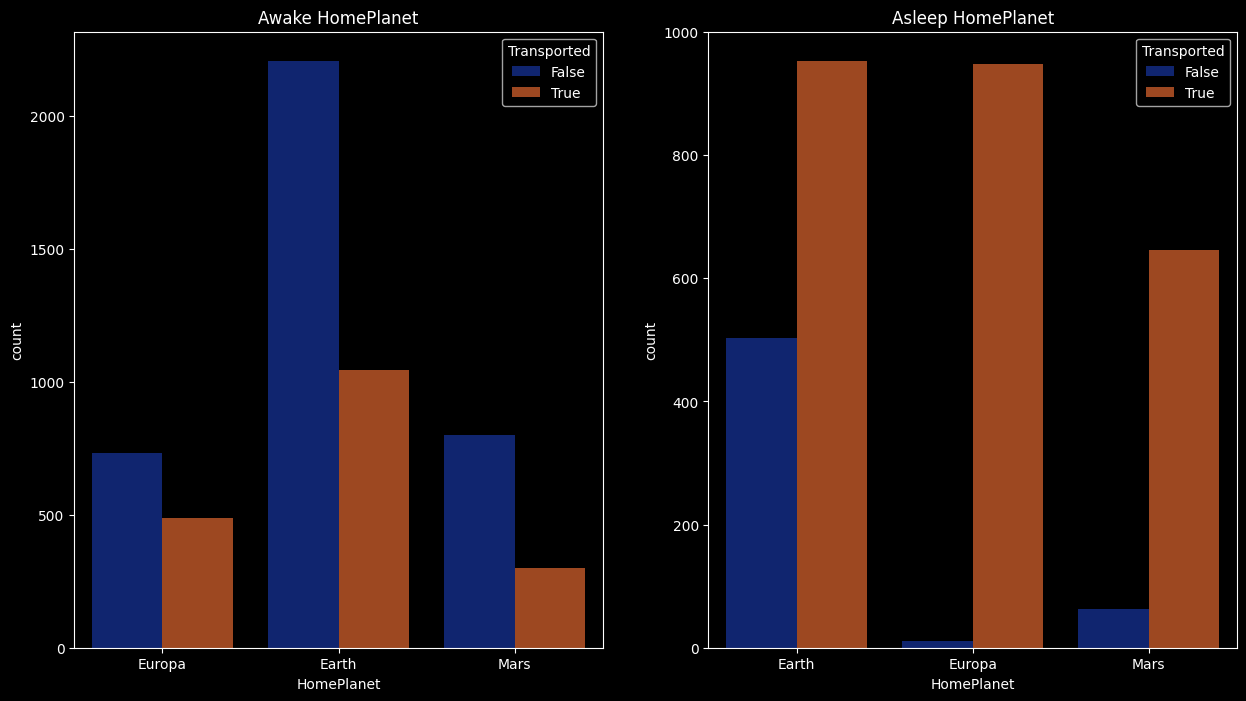

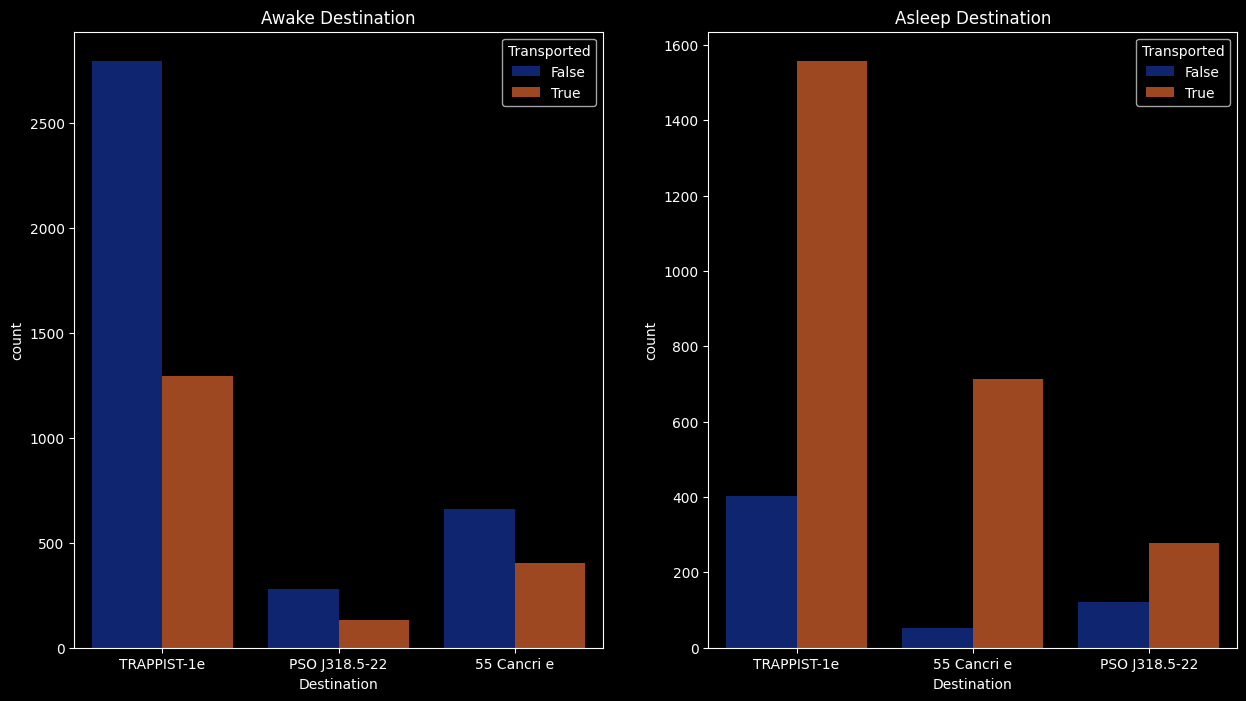

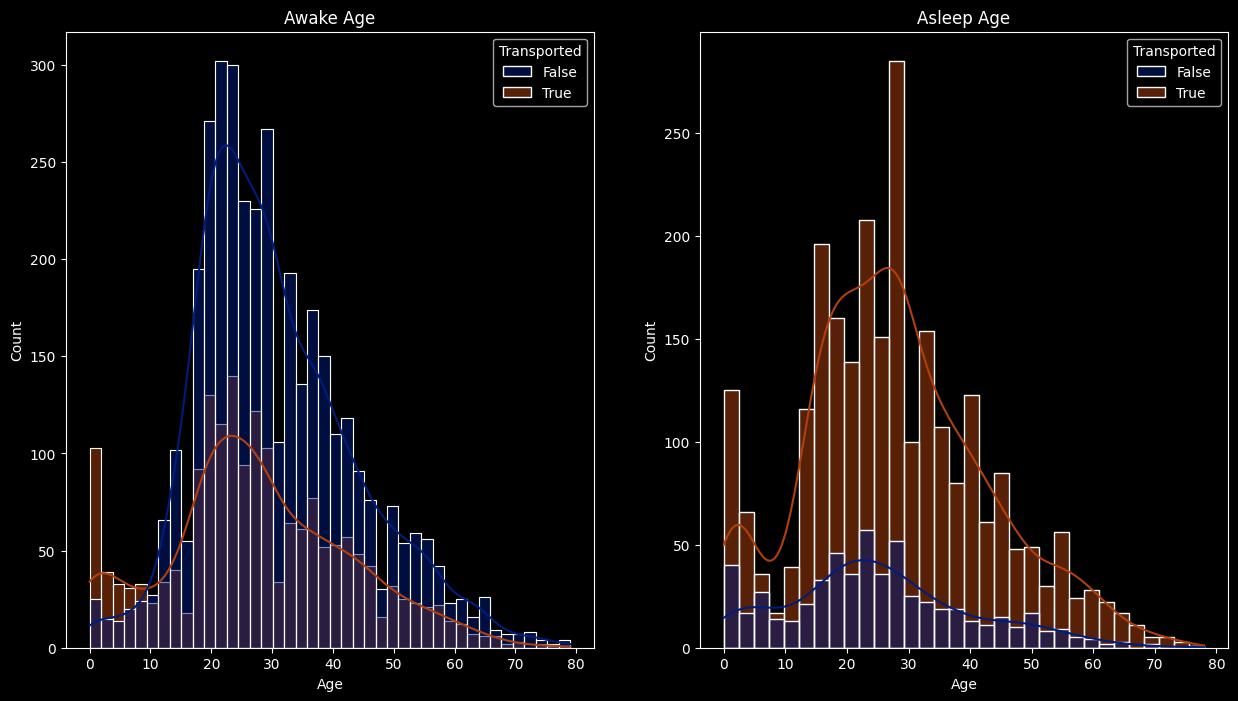

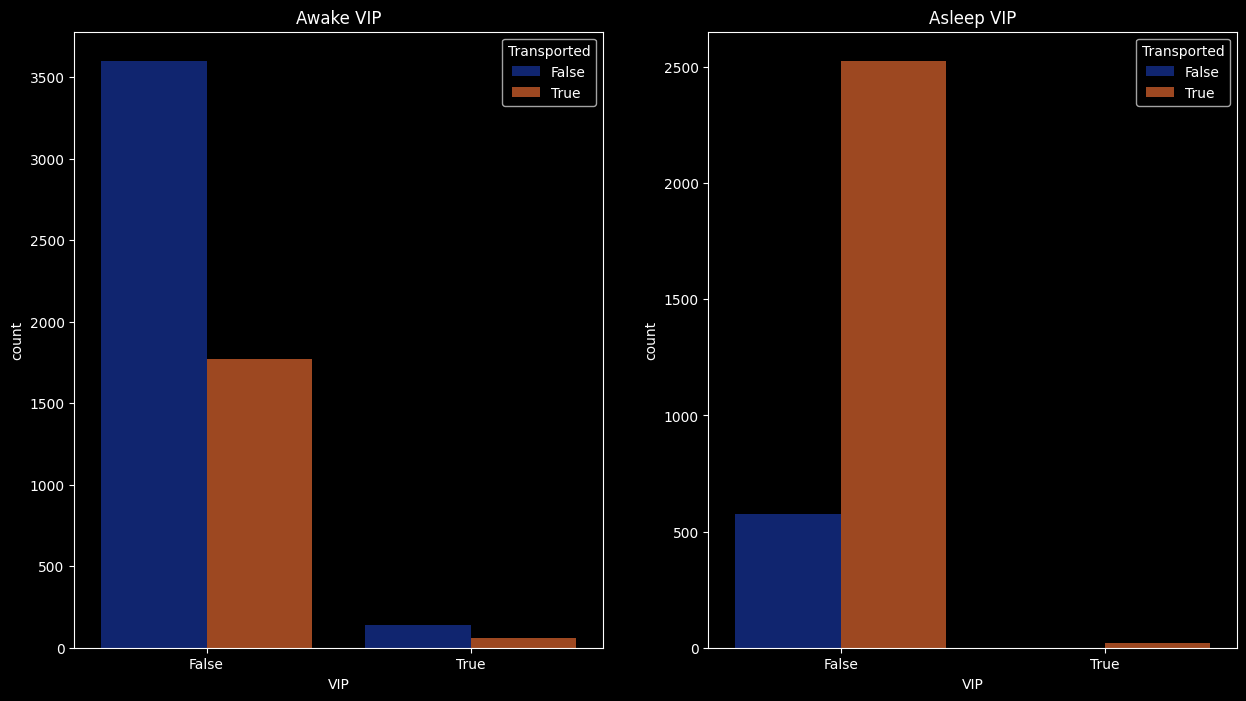

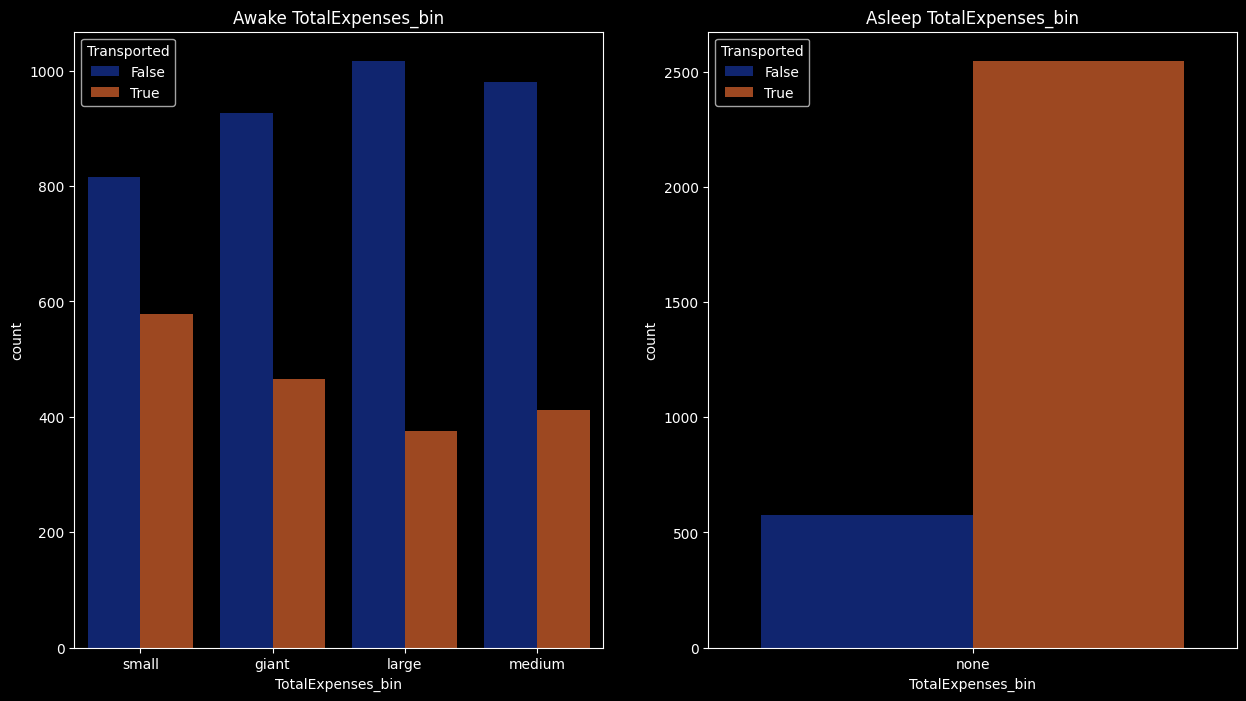

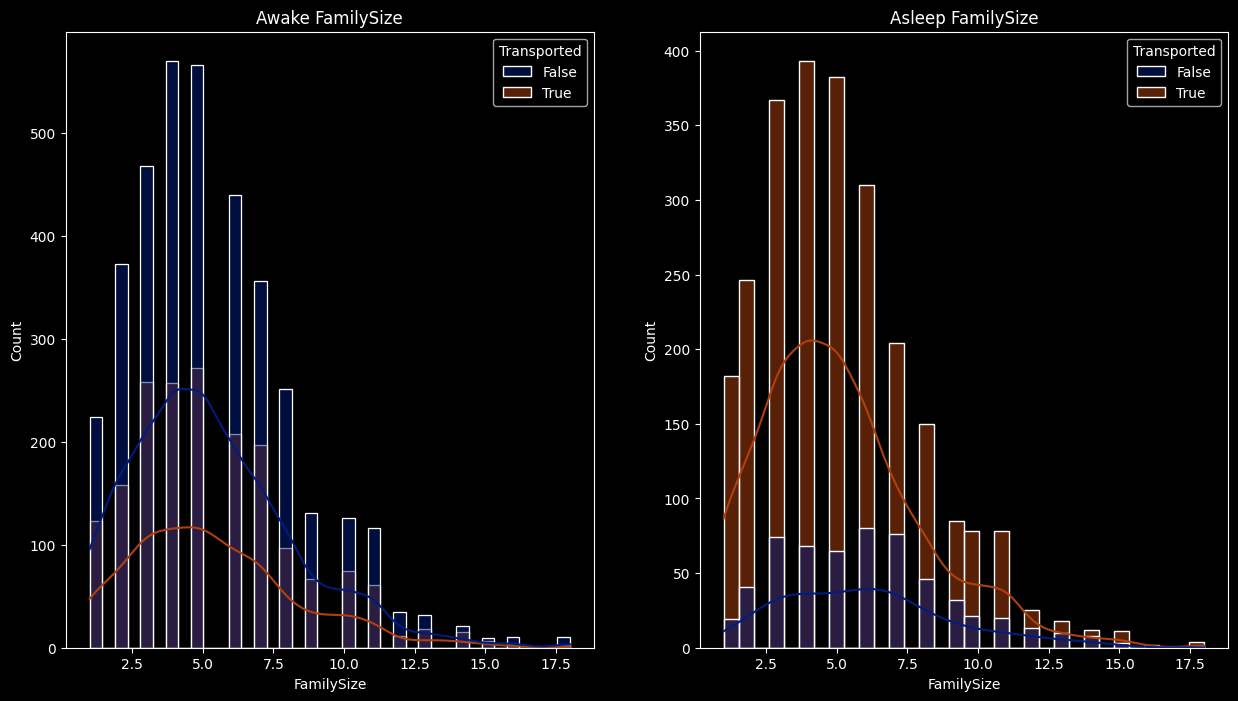

In [39]:
awake = train[train['CryoSleep'] == False]
asleep = train[train['CryoSleep'] == True]

columns_of_interest = ['HomePlanet','Destination','Age','VIP','TotalExpenses_bin','FamilySize']
for col in [x for x in columns_of_interest if x != 'Transported']:
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    if train[col].dtype in ['int64','float64']:
        sns.histplot(ax=ax[0], data=awake, x=col, hue='Transported', kde=True, palette='dark').set(title='Awake ' + col)
        try:
            sns.histplot(ax=ax[1], data=asleep, x=col, hue='Transported', kde=True, palette='dark').set(title='Asleep ' + col)
        except:
            pass
        plt.show()
    else:
        sns.countplot(ax=ax[0], data=awake, x=col, hue='Transported', palette='dark').set(title='Awake ' + col)
        sns.countplot(ax=ax[1], data=asleep, x=col, hue='Transported', palette='dark').set(title='Asleep ' + col)
        plt.show()

# Pre-processing

So this is how this is gonna go. By looking at the plots, I think I am going to eliminate the following from our features list:
-  Home Planet
-  Destination

Reason being, is that there is so much skew in the asleep / awake cases, that I am afraid the model will immediately assume survival / death based on where you were going or where you came from. Perhaps I can adjust some weighting to account for this, but for now, I am going to ignore.

Another thing we are going to end up trying is a separate model to be used for awake vs asleep. Reasoning is the same as above. There is so much skew in the asleep case, that I am afraid the model will ultimately assume you died if you were asleep, which is not always the case. Regardless, there will be some playing around. 

Features selected:
-  Age
-  VIP
-  TotalExpenses_bin
-  FamilySize
-  CryoSleep (model adjustments necessary)

# UPDATE

with a socre of 0.74865, we are now going to try adjusting the data processing into the models to improve our score. Therefore, some statements made previously in other sections may no longer be true.

Furthermore, optimizing hyperparameters gained a few percentage points here and there, but I think the proof is going to be in the data, or using mutiple models. For this trial run, we will no longer optimize hyperparameters, and just simply try to improve with more data cleaning.

In [40]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalExpenses', 'First', 'Last', 'FamilySize',
       'TotalExpenses_bin'],
      dtype='object')

In [68]:
ignore = ['PassengerId','Transported','Cabin','Name','First','Last']
features = [col for col in train.columns if col not in ignore]
targets = 'Transported'


num_cols = [col for col in features if train[col].dtypes in ['int64','float64','bool']]
cat_cols = [col for col in features if train[col].dtypes in ['object']]

In [69]:
features

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'TotalExpenses',
 'FamilySize',
 'TotalExpenses_bin']

In [70]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='bool')

train_encoded = pd.DataFrame(data=ohe.fit_transform(train[cat_cols]), columns=ohe.get_feature_names_out())
test_encoded = pd.DataFrame(data=ohe.fit_transform(test[cat_cols]), columns=ohe.get_feature_names_out())

train_model_data = pd.concat([train[num_cols], train[targets], train_encoded], axis=1)
test_model_data = pd.concat([test[num_cols], test_encoded], axis=1)


In [71]:
X = train_model_data.drop('Transported', axis=1)
y = train['Transported']

Xtest = test_model_data

In [72]:
y.value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

In [73]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=100)

# Model

We will try a schmorgizborg of models, and see if any are particularly good at getting the training and validation error down

In [74]:
def TestClassifiers(train_data, train_classes, test_data, test_classes, classifiers):
    results = {}
    for clf in classifiers:
        name = clf.__class__.__name__

        start_time = time.time()
        clf.fit(train_data, train_classes)

        acc = round(balanced_accuracy_score(test_classes, clf.predict(test_data)), 3)
        f1 = round(f1_score(y_true=test_classes, y_pred=clf.predict(test_data), average='weighted'), 3)
        stop_time = time.time()

        time_to_run = round(stop_time - start_time, 3)

        print("{} trained in {} with an F1 of : {} and an accuracy of: {}".format(name, time_to_run, f1, acc))

        results[name] = (acc, f1, time_to_run, clf)

    return results

In [75]:

classifiers = [
    XGBClassifier(),
    LGBMClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LogisticRegression(),
    RidgeClassifier(),
    GaussianNB()
]

In [76]:
results = TestClassifiers(Xtrain, ytrain, Xval, yval, classifiers=classifiers)

XGBClassifier trained in 0.383 with an F1 of : 0.784 and an accuracy of: 0.785
LGBMClassifier trained in 0.163 with an F1 of : 0.795 and an accuracy of: 0.796
RandomForestClassifier trained in 0.506 with an F1 of : 0.781 and an accuracy of: 0.78
ExtraTreesClassifier trained in 0.409 with an F1 of : 0.758 and an accuracy of: 0.758
GradientBoostingClassifier trained in 0.64 with an F1 of : 0.796 and an accuracy of: 0.798
DecisionTreeClassifier trained in 0.027 with an F1 of : 0.721 and an accuracy of: 0.721
ExtraTreeClassifier trained in 0.007 with an F1 of : 0.722 and an accuracy of: 0.722
LogisticRegression trained in 0.049 with an F1 of : 0.788 and an accuracy of: 0.788
RidgeClassifier trained in 0.008 with an F1 of : 0.778 and an accuracy of: 0.778
GaussianNB trained in 0.01 with an F1 of : 0.754 and an accuracy of: 0.76


/home/mattgpaul/Documents/Python Projects/Spaceship-Titanic/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
dump(value=[Xtrain, Xval, ytrain, yval], filename='data.joblib', compress=5)

['data.joblib']

In [78]:
def get_data():
    data = load('data.joblib')
    return data

In [79]:

def optimize_objective(trial):
    data = get_data()
    Xtrain = data[0]
    Xval = data[1]
    ytrain = data[2]
    yval = data[3]
    
    
    algorithm = trial.suggest_categorical('algorithm',['XGB','LGBM'])
    
    if algorithm == 'XGB':
        model = XGBClassifier()
        xgb_booster = trial.suggest_categorical('xgb_booster', ['gbtree','dart'])
        xgb_eta = trial.suggest_float('xgb_eta', 0.1, 0.99)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 1, 1000)
        
        model = XGBClassifier(booster=xgb_booster, eta=xgb_eta, max_depth=xgb_max_depth, n_jobs=4, random_state=8)
    else:
        lgbm_boosting = trial.suggest_categorical('lgbm_boosting', ['gbdt','dart','goss'])
        lgbm_num_iterations = trial.suggest_int('lgbm_num_iterations', 10, 1000)
        lgbm_learning_rate = trial.suggest_float('lgbm_learning_rate', 0.05, 0.99)
        
        model = LGBMClassifier(boosting_type=lgbm_boosting, num_iterations=lgbm_num_iterations, learning_rate=lgbm_learning_rate, n_jobs=4, random_state=8)
        
    model.fit(Xtrain, ytrain)
    score = f1_score(y_true=yval, y_pred = model.predict(Xval), average='weighted')
    
    return score
        

In [80]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_objective, n_trials=100)

[I 2022-09-13 21:46:38,187] A new study created in memory with name: no-name-3a02b41e-4ecd-4106-aa77-e6d092e79929
[I 2022-09-13 21:46:39,215] Trial 0 finished with value: 0.7515389554731183 and parameters: {'algorithm': 'XGB', 'xgb_booster': 'gbtree', 'xgb_eta': 0.7210554041096863, 'xgb_max_depth': 793}. Best is trial 0 with value: 0.7515389554731183.
/home/mattgpaul/Documents/Python Projects/Spaceship-Titanic/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-09-13 21:46:41,132] Trial 1 finished with value: 0.772297831068696 and parameters: {'algorithm': 'LGBM', 'lgbm_boosting': 'dart', 'lgbm_num_iterations': 631, 'lgbm_learning_rate': 0.5769058189229482}. Best is trial 1 with value: 0.772297831068696.
[I 2022-09-13 21:46:42,215] Trial 2 finished with value: 0.759035725926826 and parameters: {'algorithm': 'XGB', 'xgb_boo

In [81]:
all_trials = study.get_trials()

In [82]:
res_trials = {}
for _t in all_trials:
    res_trials[_t.number] = (_t.value, _t.params)
    
f_trials = sorted(res_trials.items(), key=lambda x: x[1][0], reverse=True)[:1]

In [83]:
f_trials

[(73,
  (0.7997813395476935,
   {'algorithm': 'LGBM',
    'lgbm_boosting': 'dart',
    'lgbm_num_iterations': 426,
    'lgbm_learning_rate': 0.1521432780490996}))]

In [84]:
final_model = LGBMClassifier(boosting_type='dart', num_iterations=426, learning_rate=0.152)
final_model.fit(Xtrain, ytrain)

/home/mattgpaul/Documents/Python Projects/Spaceship-Titanic/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(boosting_type='dart', learning_rate=0.152, num_iterations=426)

In [85]:
final_result = final_model.predict(Xtest)

In [86]:
submitme = test['PassengerId'].to_frame()
submitme['Transported'] = final_result
submitme

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [87]:
submitme.to_csv('Spaceship_Titanic_LGBM.csv', index=False)